# Titanic - Machine Learning from Disaster: постороение предиктивной модели с использованием градиентного бустинга

Крушение "Титаника" — вероятно, самое известное кораблекрушение в истории.

15 апреля 1912 года во время своего первого рейса, "непотопляемый" Титаник после столкновения с айсбергом пошел ко дну. 1502 человека из 2224 пассижиров корабля (включая команду) погибли. При этом, у определенных групп людей были более высокие шансы выжить.

В этой работе мы попробуем построить модель, которая ответит на вопрос: "кто из пассажиров имел наибольшие шансы на выживание".

**Данный ноутбук выполнен на основе данных из "легендарного" конкурса Kaggle**

## Обзор данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing

### Загрузка данных

Датасет состоит из двух частей — тренировчной и тестовой. В тестовой выборке целевой признак скрыт.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Сначала разберем тренировочный датасет

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


В тренирочном датасете 891 объект и 12 признаков (включая целевой):
- `PassengerID` — номер пассажира, по сути дублирует индекс;
- `Survived` — целевой признак, выжил ли пассажир;
- `Pclass` — класс билета, прокси-показатель статуса человека в обществе, имеет значения 1,2,3;
- `Name` — имя и фамилия человека;
- `Sex` — пол (male или female);
- `Age` — возраст, имеются пропуски (891- 714 = 177 значений - примерно 20%), имеются дробные значения (тип float64);
- `SibSp` — количество родственников — супругов, братьев или сестер на борту Титаника;
- `Parch` — количесвто родителей/детей на борту, при значении 0 у ребенка, он путешествует с няней или непрямыми родственниками;
- `Ticket` — номер билета;
- `Fare` — транспортные расходы пассажира, косвенно указывают его статус и доход, принаджлежность к соц. классу;
- `Cabin` — номер кабины, имеется большое количество пропусков;
- `Embarked` — порт посадки, C = Cherbourg, Q = Queenstown, S = Southampton.

Теперь переходим к тестовой выборке:

In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


В тестовой выборке присутствуют все те же признаки за исключением целевой. Агрегированные данные (медианы и средние) в выборках почти не отличаются.

## Предобработка данных

Для преобработки данных объеденим тестовую и тренировочные модели.

In [9]:
data = pd.concat([train,test])

### Удаление неинформативных признаков 

Часть информации о пассажире явлется избыточной и не несет пользы для модели:
- номер билета `Ticket`;
- ФИО `Name`.

Признак `Cabin` имеет слишком много пропущенных значений, чтобы применяться в обучении модели. Кроме того, предположительно не несет смысла признак `Embarked` — порт , в котором пассажир зашел на борт — однако пока мы оставим его, исходя из предположения, что в разных портах преобладали люди разного социального уровня или они размещались рядом в пределах одного класса — и соответственно имели схожие шансы выжить. 
    

In [10]:
# удаляем избыточные признаки

data = data.drop(columns=['Ticket','Name','Cabin'])

In [11]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,22.0,1,0,7.2500,S
1,2,1.0,1,female,38.0,1,0,71.2833,C
2,3,1.0,3,female,26.0,0,0,7.9250,S
3,4,1.0,1,female,35.0,1,0,53.1000,S
4,5,0.0,3,male,35.0,0,0,8.0500,S


### Работа с пропущенными значениями

В признаке `Fare` имеется единственное пропущенное значение — потеря одного объекта вряд ли существенно повлияет на точность модели, но тем не менее мы заполним пропуск медианным значением.

In [12]:
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

Прежде чем заполнить пропуски в `Embarked`, проверим влияет ли порт посадки на шанс выжить в кораблекрушении

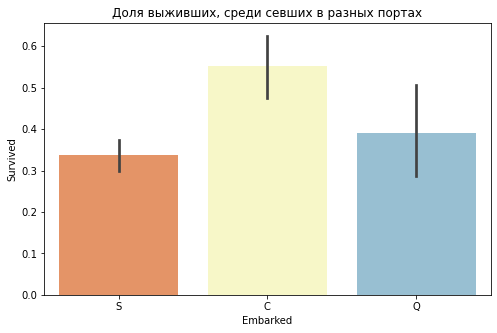

In [13]:
fig = plt.figure(figsize = (8,5))
chart = sns.barplot(x="Embarked",y="Survived",data = data, palette = "RdYlBu")
chart.set_title('Доля выживших, среди севших в разных портах')
plt.show()

У поднявшихся на борт в Cherbourg доля выживших сильно выше - более 50%, а вот среди пассажиров из Southampton'a их чуть больше 30%.

In [14]:
data[data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1.0,1,female,38.0,0,0,80.0,NaN
829,830,1.0,1,female,62.0,0,0,80.0,NaN


У двух женщин с неизвестным портом посадки на борту отсутствовали родственники и восстановить пропуски проблематично. Отбросим эти два объекта (они относятся к тренировочной выборке).

In [15]:
data = data[~data['Embarked'].isna()]

У нас остается значительное число пропусков в признаке `Age` — восстановить значения кажется затруднительным: заполним медианным значением, чтобы не терять объекты.

In [16]:
data['Age'] = data['Age'].fillna(data['Age'].median())

### Категоризация по членам семьи

Сейчас два признака хранят информацию о членах семьи на борту — заменим их на один агрегированный признак.

In [17]:
data['Family'] = data['SibSp'] + data['Parch']          # складываем значения в столбцах
data.drop(columns=['SibSp', 'Parch'], inplace=True)     # отбрасываем излишние признаки

data['Family'].value_counts()                      # смотрим на распределение по признаку

0     788
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: Family, dtype: int64

Большинство путешествовали в одиночку, а пассажиров с большим количесвтом родственников на борту вообще почти не было — уменьшим количество групп, установив для всех у кого более 5 родственников на борту значение 5.

In [18]:
data.loc[data.Family>4, 'Family'] = 5
data.Family.value_counts()

0    788
1    235
2    159
5     60
3     43
4     22
Name: Family, dtype: int64

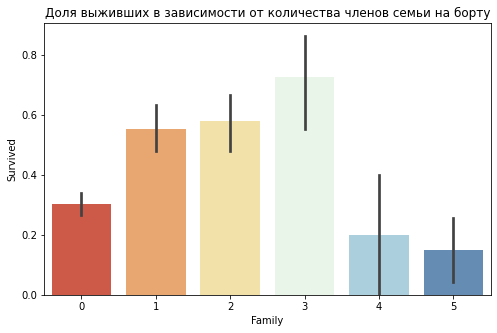

In [19]:
fig = plt.figure(figsize = (8,5))
chart = sns.barplot(x="Family",y="Survived",data = data, palette = "RdYlBu")
chart.set_title('Доля выживших в зависимости от количества членов семьи на борту')
plt.show()

Интересная картинка — семья небольшого размера увеливала шансы выжить (вот она помощь и взаимовыручка), а вот большая — существенно их снижала

In [20]:
data.info() #датасет после преобразований

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1307 non-null   int64  
 1   Survived     889 non-null    float64
 2   Pclass       1307 non-null   int64  
 3   Sex          1307 non-null   object 
 4   Age          1307 non-null   float64
 5   Fare         1307 non-null   float64
 6   Embarked     1307 non-null   object 
 7   Family       1307 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 124.2+ KB


### Обратное разделение датасета

После того, как мы произвели предобработку данных, датасет надо разделить обратно на тренировачную и тестовую выборки.

In [21]:
train = data[data.PassengerId.isin(train.PassengerId)]
test = data[data.PassengerId.isin(test.PassengerId)].drop(columns='Survived', axis=1)


In [22]:
#train = data[~data['Survived'].isna()]

In [23]:
#test = data[data['Survived'].isna()].drop(columns=['Survived'])

## Обучение модели

### Определение категориальных признаков

CatboostRegressor умеет напрямую работать с категориальными признаками — их список надо передать как параметр модели.

In [24]:
c_features = ['Sex','Embarked']

### Разбиение обучающей выборки

In [25]:
features_train = train.drop(columns=['Survived'])
target_train   = train['Survived'].astype(int)

### Обучение модели CatBoost

In [26]:
#classes = np.unique(target_train)
#weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
#class_weights = dict(zip(classes, weights))

In [27]:
model = CatBoostClassifier(cat_features=c_features, verbose = 100, random_state = 1008)

grid = {'learning_rate': [0.01,0.03, 0.1],
        'max_depth': [16]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6865461	test: 0.6870504	best: 0.6870504 (0)	total: 460ms	remaining: 7m 39s
100:	learn: 0.3927190	test: 0.4636862	best: 0.4636862 (100)	total: 16.7s	remaining: 2m 28s
200:	learn: 0.2918691	test: 0.4377338	best: 0.4374429 (198)	total: 55.8s	remaining: 3m 41s
300:	learn: 0.2309905	test: 0.4370012	best: 0.4344279 (251)	total: 1m 42s	remaining: 3m 58s
400:	learn: 0.1908150	test: 0.4417479	best: 0.4344279 (251)	total: 2m 29s	remaining: 3m 43s
500:	learn: 0.1634328	test: 0.4456061	best: 0.4344279 (251)	total: 3m 11s	remaining: 3m 10s
600:	learn: 0.1402551	test: 0.4478284	best: 0.4344279 (251)	total: 3m 56s	remaining: 2m 36s
700:	learn: 0.1150429	test: 0.4519777	best: 0.4344279 (251)	total: 5m 1s	remaining: 2m 8s
800:	learn: 0.0947325	test: 0.4587327	best: 0.4344279 (251)	total: 6m 13s	remaining: 1m 32s
900:	learn: 0.0787864	test: 0.4656041	best: 0.4344279 (251)	total: 7m 31s	remaining: 49.6s
999:	learn: 0.0656898	test: 0.4759201	best: 0.4344279 (251)	total: 9m 2s	remaining: 0us

b

In [29]:
model = CatBoostClassifier(cat_features=c_features,
                           learning_rate = 0.1,
                           max_depth = 16,
                           verbose = 100,
                           random_state = 1008)

In [30]:
model.fit(features_train, target_train)

0:	learn: 0.6282177	total: 27.8ms	remaining: 27.8s
100:	learn: 0.0915233	total: 45.4s	remaining: 6m 44s
200:	learn: 0.0312110	total: 2m 16s	remaining: 9m 3s
300:	learn: 0.0153793	total: 3m 54s	remaining: 9m 3s
400:	learn: 0.0110494	total: 5m 26s	remaining: 8m 8s
500:	learn: 0.0085173	total: 6m 56s	remaining: 6m 54s
600:	learn: 0.0068402	total: 8m 27s	remaining: 5m 36s
700:	learn: 0.0055689	total: 10m 7s	remaining: 4m 19s
800:	learn: 0.0045670	total: 12m 1s	remaining: 2m 59s
900:	learn: 0.0038854	total: 13m 53s	remaining: 1m 31s
999:	learn: 0.0035439	total: 15m 30s	remaining: 0us


### Предсказания модели и сабмит

In [31]:
predictions = model.predict(test)

In [32]:
test = pd.read_csv('test.csv')
output_1 = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output_1.to_csv('submission.csv', index=False)

Сабмит дает точность 0,74 — такой результат ниже, чем у константной модели, предсказывающей, что все женщины (и девушки) выживут.

В следующей части работы мы попробуем применить ансамбль моделей, чтобы увелить точность предсказаний. Сохраним преобработанные данные для продолжения в следующей части.

In [33]:
Survived = pd.Series(predictions, name='Survived')
Survived = Survived.astype(int)
data.to_csv('data.csv')

